[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alina-dima/nlp/blob/main/Machine_translation.ipynb)

In [1]:
!pip install datasets transformers

import datasets
import numpy as np
import ast
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


c:\Python3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def labels_to_text(labels_string):
    return [label_values_single[i] for i in range(len(label_values_single)) if labels_string[i] == 1]

def create_argument_1(row):
    conclusion = row['Conclusion'].rstrip('.').lower()
    premise = row['Premise'].rstrip('.').lower()
    stance = row['Stance']
    argument = f"The premise {premise} is {stance} the conclusion that {conclusion}. The human value {', '.join(row['Labels_text'])} supports this argument."
    argument_with_mask = f"The premise {premise} is {stance} the conclusion that {conclusion}. The human value [MASK] supports this argument."
    return argument, argument_with_mask

    
data = datasets.load_dataset('webis/Touche23-ValueEval')
label_values = ["Self-direction: thought", "Self-direction: action", "Stimulation", "Hedonism", "Achievement", "Power: dominance", "Power: resources", "Face", "Security: personal", "Security: societal", "Tradition", "Conformity: rules", "Conformity: interpersonal", "Humility", "Benevolence: caring", "Benevolence: dependability", "Universalism: concern", "Universalism: nature", "Universalism: tolerance", "Universalism: objectivity"]
label_values_single = ["thought", "action", "Stimulation", "Hedonism", "Achievement", "dominance", "resources", "Face", "personal", "societal", "Tradition", "rules", "interpersonal", "Humility", "caring", "dependability", "concern", "nature", "tolerance", "objectivity"]

data_train = data['train'].to_pandas()
data_train['Labels_text'] = data_train['Labels'].map(lambda x: labels_to_text(x))

data_train['Argument_1'], data_train['Argument_1_mask'] = zip(*data_train.apply(create_argument_1, axis=1))

data_train.head()

No config specified, defaulting to: touche23-value_eval/main
Found cached dataset touche23-value_eval (C:/Users/stefa/.cache/huggingface/datasets/webis___touche23-value_eval/main/0.0.2/109738f7f54e5a68f95e3d0b4d07797f6b7e558edce5e29c71cf0668208bfa43)
100%|██████████| 3/3 [00:00<00:00, 42.21it/s]


,Argument ID,Conclusion,Stance,Premise,Labels,Labels_text,Argument_1,Argument_1_mask
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",[societal],The premise we should ban human cloning as it ...,The premise we should ban human cloning as it ...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",[personal],The premise fast food should be banned because...,The premise fast food should be banned because...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[dominance, societal]",The premise sometimes economic sanctions are t...,The premise sometimes economic sanctions are t...
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[societal, rules, concern]",The premise capital punishment is sometimes th...,The premise capital punishment is sometimes th...
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[personal, caring, concern]",The premise factory farming allows for the pro...,The premise factory farming allows for the pro...


In [3]:
data_train_exploded = data_train.explode('Labels_text')
data_train_exploded = data_train_exploded.reset_index(drop=True)

data_train_exploded.head()

,Argument ID,Conclusion,Stance,Premise,Labels,Labels_text,Argument_1,Argument_1_mask
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",societal,The premise we should ban human cloning as it ...,The premise we should ban human cloning as it ...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",personal,The premise fast food should be banned because...,The premise fast food should be banned because...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",dominance,The premise sometimes economic sanctions are t...,The premise sometimes economic sanctions are t...
3,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",societal,The premise sometimes economic sanctions are t...,The premise sometimes economic sanctions are t...
4,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",societal,The premise capital punishment is sometimes th...,The premise capital punishment is sometimes th...


# Model for mask prediction

In [4]:
model_checkpoint = "distilbert-base-uncased"
distilbert_model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

text = '''The premise we should ban human cloning as it will only cause huge issues when you have a bunch of the same humans 
        running around all acting the same is in favor of the conclusion that we should ban human cloning. 
        The human value [MASK] supports this argument.'''

inputs = distilbert_tokenizer(text, return_tensors="pt")
token_logits = distilbert_model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == distilbert_tokenizer.mask_token_id)[1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()


print("Correct: societal")
for token in top_5_tokens:
    print(distilbert_tokenizer.decode([token]))

Correct: societal
foundation
theory
association
society
forum


In [12]:
print("Mean length is:",data_train_exploded.Argument_1.str.len().mean())
print("Min length is:",data_train_exploded.Argument_1.str.len().min())
print("Max length is:",data_train_exploded.Argument_1.str.len().max())

Mean length is: 300.41326002939417
Min length is: 151
Max length is: 959


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 12.2352
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 5.2026
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 5.9106
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 4.8583
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 4.0762
Epoch 6/20
1/1 [==============================] - 1s 1s/step - loss: 3.4713
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 3.0722
Epoch 8/20
1/1 [==============================] - 1s 1s/step - loss: 2.7549
Epoch 9/20
1/1 [==============================] - 1s 1s/step - loss: 2.5216
Epoch 10/20
1/1 [==============================] - 1s 1s/step - loss: 2.2731
Epoch 11/20
1/1 [==============================] - 2s 2s/step - loss: 2.0472
Epoch 12/20
1/1 [==============================] - 1s 1s/step - loss: 1.9378
Epoch 13/20
1/1 [====

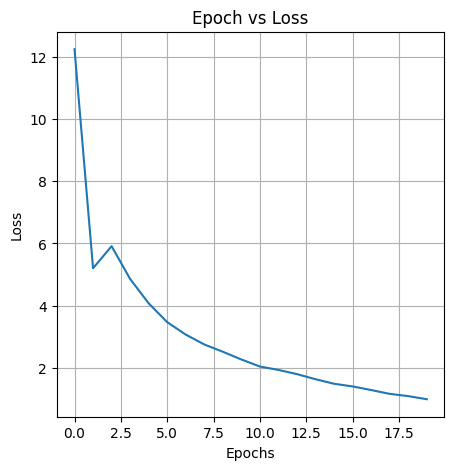

In [23]:
from transformers import BertTokenizer, TFBertForMaskedLM
import tensorflow as tf
import os
import numpy as np
import re
import matplotlib.pyplot as plt


arguments_concat = ' '.join(data_train_exploded["Argument_1"]) 
arguments_concat_masked = ' '.join(data_train_exploded["Argument_1_mask"]) 


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')

inputs = tokenizer(arguments_concat, max_length=300,truncation=True,padding='max_length',return_tensors='tf')
inputs_masked = tokenizer(arguments_concat_masked, max_length=300,truncation=True,padding='max_length',return_tensors='tf')

print(inputs.keys())

inputs['labels'] = inputs['input_ids']
inputs['input_ids'] = inputs_masked['input_ids']
inputs.keys()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
history = model.fit([inputs.input_ids,inputs.attention_mask],inputs.labels,verbose=1,batch_size=64,epochs=20)

losses = history.history['loss']
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
ax1.plot(range(len(losses)),losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Epoch vs Loss")
plt.grid()
plt.show()

In [29]:
from transformers import pipeline

text = '''The premise we should ban human cloning as it will only cause huge issues when you have a bunch of the same humans 
        running around all acting the same is in favor of the conclusion that we should ban human cloning. 
        The human value [MASK] supports this argument.'''


mask_filler = pipeline("fill-mask", model=model, tokenizer=tokenizer)

preds = mask_filler(text)

for pred in preds:
    print(f">>> {pred['token_str']} - score: {pred['score']}")

>>> societal - score: 0.3843441605567932
>>> dominance - score: 0.12334126979112625
>>> human - score: 0.1224827691912651
>>> argument - score: 0.0678839385509491
>>> personal - score: 0.04147784784436226
